In [23]:
from sklearn.preprocessing import StandardScaler
import numpy as np
from tqdm import tqdm
import pandas as pd
import torch
import torch.nn as nn
import networkx as nx
import matplotlib.pyplot as plt

In [9]:
def get_data(split: str):
    df = pd.read_csv(f'diamonds_{split}.csv')
    df = df.rename(columns = {'Unnamed: 0': 'Index'})
    # print(df.dtypes)
    x = df.drop(['Index', 'price'], axis = 1) # index col not needed
    # print(x.describe())
    y = df['price']
    # print(y.describe())
    # x_arr = x.to_numpy()
    # y_arr = y.to_numpy()
    # # print(x_arr[1])
    # print(y_arr[0])
    return x, y


In [10]:
def ohe(df, col: str):
  visited = []
  for val in df[col]:
    if val not in visited:
      visited.append(val)
  for val in visited:
    if f'{val}_{col}' not in df.columns:
      df[f'{val}_{col}'] = df[col].apply(lambda x: 1 if x == val else 0)

  df = df.drop(col, axis = 1)
  return df

In [11]:
def feature_engineering(split, ):
  x, y = get_data(split)
  x = ohe(x, 'color')
  x = ohe(x, 'cut')
  x = ohe(x, 'clarity')
  scaler = StandardScaler()
  scaler.fit(y.to_numpy().reshape(-1, 1))
  y = scaler.transform(y.to_numpy().reshape(-1, 1))
  n_feats = x.shape[1]
  # print(n_feats)
  x = x.to_numpy()
  return x, y, n_feats


In [84]:
def relu(z: np.ndarray):
    return np.maximum(0, z)

def sigmoid(z: np.ndarray):
    return 1 / (1 + np.exp(-z))

def tanh(z: np.ndarray | int | float):
    res = ((np.exp(z) - np.exp(-z))/(np.exp(z) + np.exp(-z)))
    assert np.abs(res - np.tanh(z)) <= 1e-5
    return res

def half_mse(yhat, y, W: list[np.ndarray], alpha):
    y = y.reshape(-1, 1)
    yhat = yhat.reshape(-1, 1)

    loss = 0.5 * np.mean((y - yhat) ** 2)
    reg = (alpha/2)
    reg_param = 0
    for w in W:
        reg_param += (np.sum(w ** 2))
    reg *= reg_param
    return loss + reg

def forward_prop(x, y, W: list[np.ndarray], b: list[np.ndarray], alpha, act_fn):
    if len(W) != len(b):
        print('unequal amount of weights and biases')
        return None

    if len(x.shape) == 1:
        x = x.reshape(1, -1) # if theres 1 sample

    x_col = x.T
    # print(f'x col shape: {x_col.shape}')
    # print(f'w[0] shape: {W[0].shape}')

    z = {}
    h = {}

    z[0] = W[0] @ x_col + b[0][:, np.newaxis]
    h[0] = act_fn(z[0])

    for w in range(1, len(W)):
        # print(f'Weight at index {w}: {W[w].shape}')
        # print(f'activation at index {w-1}: {h[w-1].shape}')
        # print(f'bias at index {w}: {b[w].shape}')

        z[w] = W[w] @ h[w-1] + b[w][:, np.newaxis]

        if w < len(W) - 1 or act_fn == sigmoid:
            h[w] = act_fn(z[w])
        else:
            h[w] = z[w]

    # for k, v in z.items():
        # print(f'z layer {k}: {v.shape}')
    # for k, v in h.items():
        # print(f'h layer {k}: {v.shape}')

    y_hat = h[len(W) - 1] if len(W) - 1 in h else z[len(W) - 1]
    # print(f'y_hat shape: {y_hat.shape}')

    if len(y.shape) == 1:
        y = y.reshape(-1, 1)

    loss = half_mse(y_hat, y, W, alpha)

    return loss, z, h, x, y_hat

def back_prop(X, y, W: list[np.ndarray], B: list[np.ndarray], alpha, act_fn):
    if len(X.shape) == 1:
        X = X.reshape(1, -1)
    loss, z, h, x, yhat = forward_prop(X, y, W, B, alpha, act_fn)

    if len(y.shape) == 1:
        y = y.reshape(-1, 1)
    dW = []
    dB = []
    n_layers = len(W)

    delta = None
    for i in range(n_layers - 1, -1, -1):

        if i == n_layers - 1:
            delta = -(y - yhat.T).T
        else:
            if act_fn == relu:
                delta = (W[i+1].T @ delta) * (z[i] > 0)
            elif act_fn == sigmoid:
                delta = (W[i+1].T @ delta) * (h[i] * (1 - h[i]))
            elif act_fn == tanh:
                delta = (W[i+1].T @ delta) * (1 - h[i]**2)
            else:
                print('Unsupported activation function')
                return None

        if i > 0:
            dW_i = delta @ h[i-1].T / X.shape[0]
        else:
            dW_i = delta @ X / X.shape[0]

        dB_i = np.mean(delta, axis=1)

        dW_i = dW_i + alpha * W[i]

        dW.insert(0, dW_i)
        dB.insert(0, dB_i)

    return dW, dB, loss




def train(x_train: np.ndarray, y_train: np.ndarray, W: list[np.ndarray], b: list[np.ndarray],
          learning_rate=1e-3, batch_size=32, num_epochs=100, reg_param=1e-4, clip_val=1.0, act_fn=relu, tol: float = 0.001, min_iter = 10):
    losses = []
    # print(f"Number of weight matrices: {len(W)}")

    for epoch in tqdm(range(num_epochs)):
        epoch_loss = 0
        idx = np.random.permutation(x_train.shape[0])
        x_train_shuffled, y_train_shuffled = x_train[idx], y_train[idx]

        for i in range(0, x_train.shape[0], batch_size):
            batch_x = x_train_shuffled[i:i+batch_size]
            batch_y = y_train_shuffled[i:i+batch_size]

            # print(f"Batch x shape: {batch_x.shape}")


            dW, dB, loss = back_prop(batch_x, batch_y, W, b, reg_param, act_fn)

            # print(f"Number of dW matrices: {len(dW)}")
            # print(f"Number of dB vectors: {len(dB)}")

            for j in range(len(W)):
                W[j] -= learning_rate * np.clip(dW[j], -clip_val, clip_val)
                b[j] -= learning_rate * np.clip(dB[j], -clip_val, clip_val)

            epoch_loss += loss

        avg_epoch_loss = epoch_loss / (x_train.shape[0] // batch_size + 1)
        losses.append(avg_epoch_loss)
        if np.abs(losses [epoch] - losses [epoch - 1]) < tol and epoch > min_iter:
          # print (f'{losses [epoch] - losses [epoch - 1]}')
          print(f"Epoch {epoch+1}, Loss: {avg_epoch_loss}")
          print(f'Stopped early because {losses[epoch]} and {losses[epoch-1]} are too similar', )
          return losses, W, b


        print(f"Epoch {epoch+1}, Loss: {avg_epoch_loss}")

    return losses, W, b



def create_computational_graph(W: list[np.ndarray], b: list[np.ndarray], act_fn) -> nx.DiGraph:
    n_layers = len(W)
    G = nx.DiGraph()
    activation_name = act_fn.__name__

    input_dim = W[0].shape[1]
    output_dim = W[-1].shape[0]

    G.add_node("X", label=f"Input\n(dim={input_dim}, or n_features)", pos=(0, 0), color="lightblue", shape="box")

    layer_width = 5
    node_height = 2


    for i in range(n_layers):
        w_y_pos = node_height * (i + 1)
        b_y_pos = -node_height * (i + 1)

        w_shape = W[i].shape
        G.add_node(f"W{i}",
                  label=f"W[{i}]\nShape: {w_shape}\nNorm: {np.linalg.norm(W[i]):.4f}",
                  pos=(i * layer_width + 0.5, w_y_pos),
                  color="orange")

        b_shape = b[i].shape
        G.add_node(f"b{i}",
                  label=f"b[{i}]\nShape: {b_shape}\nNorm: {np.linalg.norm(b[i]):.4f}",
                  pos=(i * layer_width + 0.5, b_y_pos),
                  color="lightgreen")

    for i in range(n_layers):
        layer_x_pos = (i + 1) * layer_width

        if i == 0:
            z_label = f"z[{i}] = W[{i}] @ X + b[{i}]"
            G.add_edge("X", f"z{i}", color="black")
        else:
            z_label = f"z[{i}] = W[{i}] @ h[{i-1}] + b[{i}]"
            G.add_edge(f"h{i-1}", f"z{i}", color="black")

        G.add_node(f"z{i}", label=z_label, pos=(layer_x_pos, 0), color="lightcoral")
        G.add_edge(f"W{i}", f"z{i}", color="black")
        G.add_edge(f"b{i}", f"z{i}", color="black")

        if i < n_layers - 1 or act_fn == sigmoid:
            h_label = f"h[{i}] = {activation_name}(z[{i}])"
            h_y_pos = -1
            G.add_node(f"h{i}", label=h_label, pos=(layer_x_pos, h_y_pos), color="yellow")
            G.add_edge(f"z{i}", f"h{i}", color="black")

    output_x = (n_layers + 1) * layer_width

    G.add_node("output",
              label=f"Output\n(dim={output_dim})",
              pos=(output_x, 0),
              color="lightblue",
              shape="box")


    ed = ([e for e in G.edges])
    G.add_edge(ed[-1][1], 'output', color = 'black')

    return G

def visualize_network(W: list[np.ndarray], b: list[np.ndarray], act_fn,
                      title: str = "Neural Network Architecture",
                      filename: str = "arch.png"):
    G = create_computational_graph(W, b, act_fn)
    title += f' With {act_fn.__name__} Activation Function'


    fig_width = 3 + len(W) * 3
    fig_height = 8
    plt.figure(figsize=(fig_width, fig_height))
    pos = nx.get_node_attributes(G, 'pos')
    node_colors = [G.nodes[n].get('color', 'lightgray') for n in G.nodes()]
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=2500, alpha=0.8)
    nx.draw_networkx_edges(G, pos, width=1.5, alpha=0.7, arrows=True, arrowsize=15)
    labels = nx.get_node_attributes(G, 'label')
    nx.draw_networkx_labels(G, pos, labels=labels, font_size=9, font_weight='bold')

    plt.title(title, fontsize=16)
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()



In [62]:
if __name__ == "__main__":
    x_train, y_train, n_feats = feature_engineering('train')


    n_hidden = 64
    n_out = 1

    W1 = np.random.randn(n_hidden, n_feats) * 0.01
    b1 = np.zeros(n_hidden)
    W2 = np.random.randn(n_hidden, n_hidden) * 0.01
    b2 = np.zeros(n_hidden)
    W3 = np.random.randn(n_out, n_hidden) * 0.01
    b3 = np.zeros(n_out)
    losses, W, B = train(x_train, y_train, [W1, W2, W3], [b1, b2, b3])
    print(f'final train loss: {losses[-1]}')


  1%|          | 1/100 [00:00<00:48,  2.06it/s]

Epoch 1, Loss: 0.5000035644604718


  2%|▏         | 2/100 [00:00<00:47,  2.06it/s]

Epoch 2, Loss: 0.4999696777551176


  3%|▎         | 3/100 [00:01<00:46,  2.11it/s]

Epoch 3, Loss: 0.4996054979526581


  4%|▍         | 4/100 [00:01<00:46,  2.07it/s]

Epoch 4, Loss: 0.49935919489747177


  5%|▌         | 5/100 [00:02<00:45,  2.07it/s]

Epoch 5, Loss: 0.4987368494514897


  6%|▌         | 6/100 [00:02<00:45,  2.05it/s]

Epoch 6, Loss: 0.49742250105932667


  7%|▋         | 7/100 [00:03<00:44,  2.07it/s]

Epoch 7, Loss: 0.49391614176431026


  8%|▊         | 8/100 [00:03<00:44,  2.05it/s]

Epoch 8, Loss: 0.48013022202000805


  9%|▉         | 9/100 [00:04<00:43,  2.09it/s]

Epoch 9, Loss: 0.38765161970049966


 10%|█         | 10/100 [00:04<00:43,  2.06it/s]

Epoch 10, Loss: 0.14378469190926985


 11%|█         | 11/100 [00:05<00:42,  2.08it/s]

Epoch 11, Loss: 0.09060222878336936


 12%|█▏        | 12/100 [00:05<00:42,  2.06it/s]

Epoch 12, Loss: 0.08309947863055145


 13%|█▎        | 13/100 [00:06<00:41,  2.08it/s]

Epoch 13, Loss: 0.08205453779232791


 13%|█▎        | 13/100 [00:06<00:45,  1.92it/s]

Epoch 14, Loss: 0.08262137055947272
Stopped early because 0.08262137055947272 and 0.08205453779232791 are too similar
final train loss: 0.08262137055947272


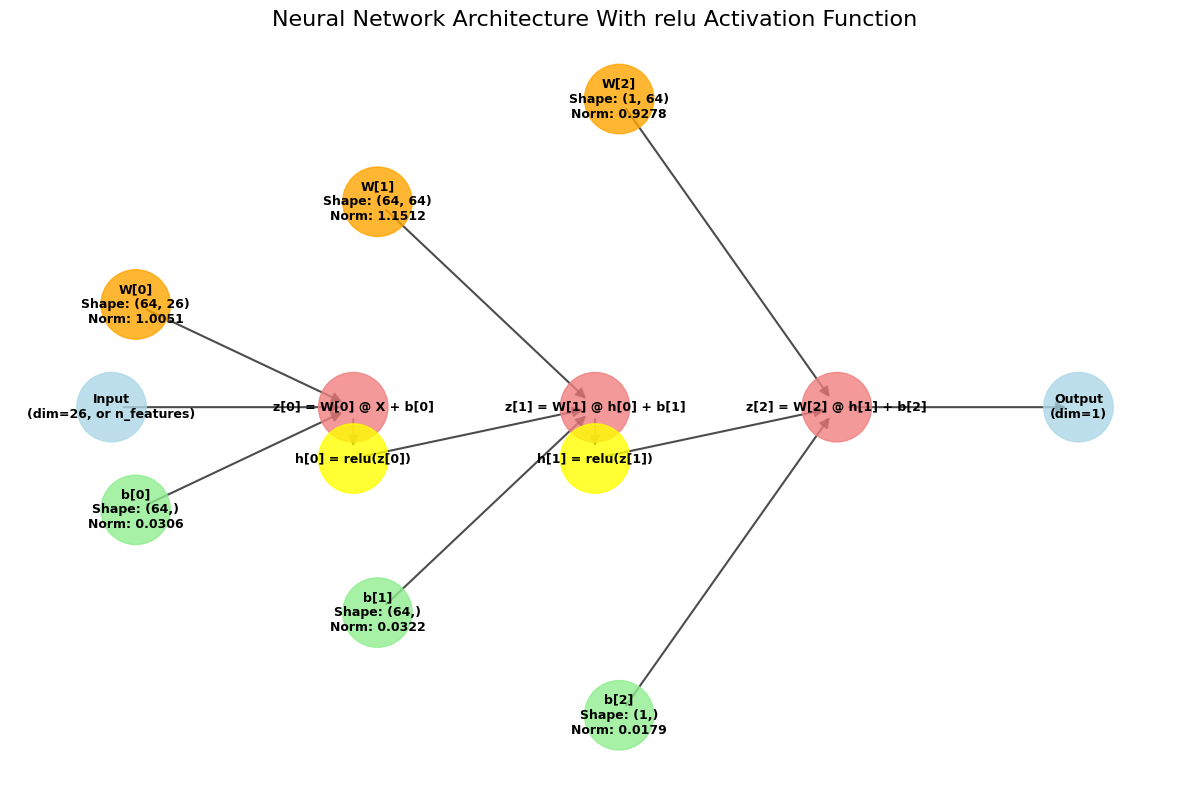

In [85]:
visualize_network(W, B, relu)

In [86]:
x_val, y_val, val_n = feature_engineering('val')
reg_param=1e-4

pred  = forward_prop(x_val, y_val, W, B , alpha = reg_param, act_fn = relu)

print(f'performance (loss wise) on the validation data: {pred[0]:.4f}')
n = len(y_val)

aic_val = n * np.log(pred[0]) + 2 * val_n
bic_val = n * np.log(pred[0]) + val_n * np.log(n)
print('Validation AIC:', aic_val)
print('Validation BIC:', bic_val)

performance (loss wise) on the validation data: 0.0813
Validation AIC: -13486.01917444463
Validation BIC: -13314.600069348438


#K-Fold??? More Splitting? Grid Search??? More Fun in the Future 💳

# TEST TO COME ...